<a href="https://colab.research.google.com/github/Abdulrafayshiekh/Git-Bash-Codex/blob/main/Predictive_Maintenance_System_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Cross-Validated R² Scores: [0.99992478 0.99939788 0.99991922 0.99992577 0.9999259 ]
✅ Average R²: 1.00
✅ Cross-Validated RMSE Scores: [2.42556627 7.0269548  2.54861916 2.47044757 2.44680748]
✅ Average RMSE: 3.38


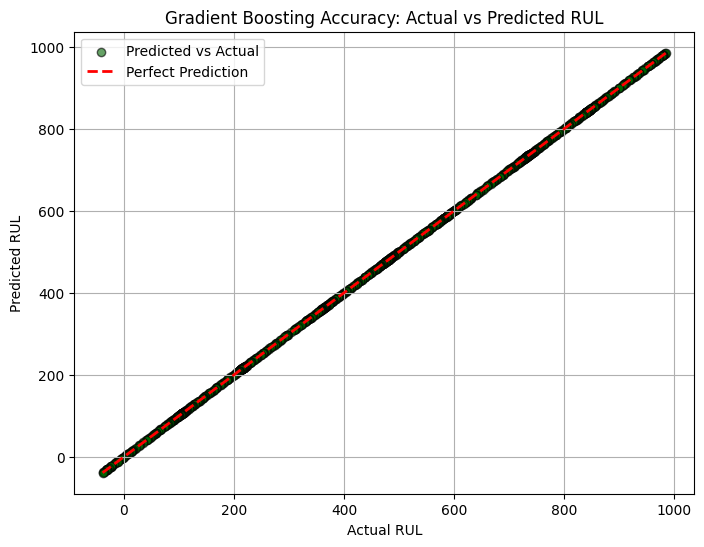

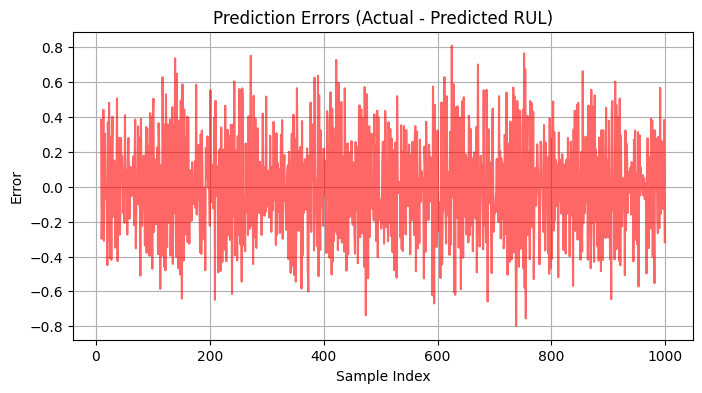

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer

# ====================================================
# 🔹 Step 1: Generate Synthetic Sensor Data
# ====================================================
def generate_sensor_data(n=1000, seed=42):
    np.random.seed(seed)
    time = np.arange(n)
    vibration = np.sin(0.02 * time) + np.random.normal(0, 0.1, n)
    temperature = 70 + 5 * np.sin(0.01 * time) + np.random.normal(0, 0.5, n)
    sound = np.random.normal(0.5, 0.05, n)

    df = pd.DataFrame({
        'timestamp': time,
        'vibration': vibration,
        'temperature': temperature,
        'sound': sound
    })
    return df

df = generate_sensor_data()

# ====================================================
# 🔹 Step 2: Balanced RUL Simulation
# ====================================================
df['RUL'] = (
    1000
    - df['timestamp']
    - 20 * np.clip(df['vibration'], 0, 1)
    - 20 * np.clip(df['sound'], 0, 1)
    - 20 * np.abs(df['temperature'] - 70) / 10
    + 15 * np.sin(0.05 * df['timestamp'])
)

# ====================================================
# 🔹 Step 3: Feature Engineering (Rolling Window = 10)
# ====================================================
window = 10
df['vibration_mean'] = df['vibration'].rolling(window).mean()
df['vibration_std'] = df['vibration'].rolling(window).std()
df['vibration_max'] = df['vibration'].rolling(window).max()

df['sound_mean'] = df['sound'].rolling(window).mean()
df['sound_std'] = df['sound'].rolling(window).std()
df['sound_range'] = df['sound'].rolling(window).max() - df['sound'].rolling(window).min()
df['sound_skew'] = df['sound'].rolling(window).skew()

df['temperature_mean'] = df['temperature'].rolling(window).mean()
df['temperature_std'] = df['temperature'].rolling(window).std()
df['temperature_range'] = df['temperature'].rolling(window).max() - df['temperature'].rolling(window).min()

df.dropna(inplace=True)

# ====================================================
# 🔹 Step 4: Feature Selection and Scaling
# ====================================================
features = [
    'vibration_mean', 'vibration_std', 'vibration_max',
    'sound_mean', 'sound_std', 'sound_range', 'sound_skew',
    'temperature_mean', 'temperature_std', 'temperature_range'
]

# Add scaled timestamp
scaler = StandardScaler()
df['timestamp_scaled'] = scaler.fit_transform(df[['timestamp']])
features.append('timestamp_scaled')

X_scaled = scaler.fit_transform(df[features])
y = df['RUL']

# ====================================================
# 🔹 Step 5: Model Setup (Gradient Boosting)
# ====================================================
model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    random_state=42
)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse_score, greater_is_better=False)

# ====================================================
# 🔹 Step 6: Evaluate with Cross-Validation
# ====================================================
r2_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='r2')
rmse_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring=rmse_scorer)

print(f"✅ Cross-Validated R² Scores: {r2_scores}")
print(f"✅ Average R²: {r2_scores.mean():.2f}")
print(f"✅ Cross-Validated RMSE Scores: {-rmse_scores}")
print(f"✅ Average RMSE: {-rmse_scores.mean():.2f}")

# ====================================================
# 🔹 Step 7: Train Final Model for Visualization
# ====================================================
model.fit(X_scaled, y)
y_pred = model.predict(X_scaled)

# ====================================================
# 🔹 Step 8: Accuracy Visualization
# ====================================================
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, color='darkgreen', alpha=0.6, edgecolor='k', label='Predicted vs Actual')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Gradient Boosting Accuracy: Actual vs Predicted RUL')
plt.legend()
plt.grid(True)
plt.show()

# ====================================================
# 🔹 Step 9: Error Plot
# ====================================================
errors = y - y_pred
plt.figure(figsize=(8, 4))
plt.plot(errors, color='red', alpha=0.6)
plt.title("Prediction Errors (Actual - Predicted RUL)")
plt.xlabel("Sample Index")
plt.ylabel("Error")
plt.grid(True)
plt.show()
